In [103]:
from rich import print
import pandas as pd
import numpy as np
import math
import ast
from dataclasses import dataclass
from collections import defaultdict
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import random

In [83]:
class Participant:
    def __init__(self, id, university, interests, preferred_role, friend_registration, preferred_team_size, availability,
                 programming_skills, interest_in_challenges, experience, languages_ordered, maturity, Tryhard, Rookie, Learner, Portfolio):
        self.id = id
        self.university = university
        self.interests = interests
        self.preferred_role = preferred_role
        self.friend_registration = friend_registration
        self.preferred_team_size = preferred_team_size
        self.availability = availability
        self.programming_skills = programming_skills
        self.interest_in_challenges = interest_in_challenges
        self.experience = experience
        self.languages_ordered = languages_ordered
        self.maturity = maturity
        self.Tryhard = Tryhard
        self.Rookie = Rookie
        self.Learner = Learner
        self.Portfolio = Portfolio

In [84]:
def dist_university(university_1, university_2) :
    if university_1 == university_2:
        return 0 
    else:
        return 10

In [85]:
def dist_friends(friend_registration_1, friend_registration_2, id_1, id_2):
    if id_1 in friend_registration_2 and id_2 in friend_registration_1:
        return 0
    elif id_1 in friend_registration_2 or id_2 in friend_registration_1:
        return 1
    return 10

In [86]:
#No usar
def dist_age_year_of_study(age_1, age_2, year_1, year_2, age_weight, year_weigth) -> float:
    age_distance = abs(age_1 - age_2)
    year_distance = abs(year_1 - year_2)
    return (age_weight * age_distance + year_weigth * year_distance) / (age_distance + year_distance)


In [87]:
def dist_one_hot_encoding(x, y):
    return sum([1 if x_i != y_i else 0 for x_i, y_i in zip(x, y)])

In [88]:
def dist_programming_skills(skills_1, skills_2) -> float:
    avg_level_1 = sum(skills_1.values()) / len(skills_1) if skills_1 else 0
    
    avg_level_2 = sum(skills_2.values()) / len(skills_2) if skills_2 else 0
    
    distance_avg_levels = abs(avg_level_1 - avg_level_2)
    
    all_skills = set(skills_1.keys()).union(set(skills_2.keys()))
    
    distance_union = 1 / len(all_skills) if all_skills else 10 
    return distance_avg_levels + distance_union


In [89]:
#No usar
def dist_experience(exp_1, exp_2, hackathons_1, hackathons_2, experience_weights) -> float:
    exp_distance = abs(exp_1 - exp_2)
    hackathon_distance = abs(np.log1p(hackathons_1) - np.log1p(hackathons_2))
    total_distance = experience_weights[0] * exp_distance + experience_weights[1] * hackathon_distance
    return total_distance

In [90]:
def dist_preferred_role(role_1, role_2):
    if role_1 == role_2:
        return 1.0  

    if role_1 == "Don't know" or role_2 == "Don't know":
        return 1 / 0.2  

    if role_1 == "Don't care" or role_2 == "Don't care":
        return 0.5  

    return 0.0

In [91]:
#No usar
def euclidean_distance(vector_1, vector_2):
    squared_diff_sum = sum((x - y) ** 2 for x, y in zip(vector_1, vector_2))
    
    return math.sqrt(squared_diff_sum)

In [92]:
def dist_language(languages_1, languages_2):
    if not languages_1 or not languages_2:  
        return 0
    
    common_languages = set(languages_1).intersection(set(languages_2))
    
    if not common_languages:  
        return 100

    distance = 0
    for i, lang_1 in enumerate(languages_1):
        for j, lang_2 in enumerate(languages_2):
            if lang_1 == lang_2:
                d = abs(i - j)
                return d + math.exp(i+j) - 1

In [93]:
df = pd.read_csv('clean_data_actualitzat.csv')
df.head()

,id,university,interests,preferred_role,friend_registration,preferred_team_size,availability,programming_skills,interest_in_challenges,experience,languages_ordered,maturity,Tryhard,Rookie,Learner,Portfolio
0,2ebad15c-c0ef-4c04-ba98-c5d98403a90c,Universitat Internacional de Catalunya (UIC),"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Design,[],4,"[1, 1, 0, 1, 1]","{'Data Visualization': 2, 'Flask': 4, 'React N...","['Mango Challenge', 'Restb.ai Challenge', 'AED...",4.394449,"['Catalan', 'English']",4.6,0.011441,0.036347,0.011704,0.000000
1,a00428a2-14a2-4fb1-838a-22394778ec88,Universitat Pompeu Fabra (UPF),"[0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...",Analysis,[],3,"[1, 0, 1, 0, 1]","{'React': 4, 'PostgreSQL': 5, 'Figma': 7, 'SQL...","['AED Challenge', 'Mango Challenge', 'Restb.ai...",7.167038,['English'],3.4,0.021213,0.000000,0.036705,0.036051
2,ab4b5790-0e6b-43db-bbaa-8670554f0cc8,Universidad de Sevilla,"[0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...",Analysis,[],4,"[1, 1, 1, 1, 1]","{'PostgreSQL': 4, 'TensorFlow': 5, 'Computer V...","['Restb.ai Challenge', 'Mango Challenge', 'AED...",4.394449,"['Spanish', 'English', 'French', 'German', 'It...",3.6,0.017565,0.000000,0.027865,0.000000
3,cda2fafe-4b1e-4581-9fe0-1fb6d3e79aa3,Universitat Internacional de Catalunya (UIC),"[0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, ...",Design,"['13a8194a-79a9-4004-8711-e6d89efa0014', '2a48...",4,"[1, 1, 0, 1, 1]","{'IoT': 4, 'HTML/CSS': 6, 'MongoDB': 5, 'Block...","['Restb.ai Challenge', 'AED Challenge', 'Mango...",4.394449,"['Catalan', 'English']",3.6,0.036809,0.000000,0.048515,0.043992
4,624f4677-d31a-4ecf-a7de-5df7392f9579,Universitat Politècnica de Catalunya (UPC),"[1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, ...",Design,[],4,"[1, 1, 1, 1, 1]","{'iOS Development': 2, 'Flask': 6, 'TensorFlow...","['Restb.ai Challenge', 'AED Challenge', 'Mango...",4.394449,['English'],3.4,0.100958,0.034948,0.000000,0.000000


In [94]:
participants_dict = {}

for _, row in df.iterrows():
    programming_skills = ast.literal_eval(row['programming_skills'])  
    interests = ast.literal_eval(row['interests']) 
    friend_registration = ast.literal_eval(row['friend_registration'])  
    availability = ast.literal_eval(row['availability'])  
    interest_in_challenges = ast.literal_eval(row['interest_in_challenges'])  
    languages_ordered = ast.literal_eval(row['languages_ordered'])  

    
    participant = Participant(
        id=row['id'],
        university=row['university'],
        interests=interests,  
        preferred_role=row['preferred_role'],
        friend_registration=friend_registration,  
        preferred_team_size=row['preferred_team_size'],
        availability=availability,  
        programming_skills=programming_skills,  
        interest_in_challenges=interest_in_challenges,  
        experience=row['experience'],
        languages_ordered=languages_ordered,  
        maturity=row['maturity'],
        Tryhard=row['Tryhard'],
        Rookie=row['Rookie'],
        Learner=row['Learner'],
        Portfolio=row['Portfolio']
    )
    
    participants_dict[row['id']] = participant

In [95]:
def get_min_max_values(participants_dict, weights):
    # Inicialitzar els valors mínims i màxims per cada atribut
    min_values = {
        'university': float('inf'),
        'interests': float('inf'),
        'preferred_role': float('inf'),
        'availability': float('inf'),
        'programming_skills': float('inf'),
        'interests_in_challenges': float('inf'),
        'languages': float('inf'),
        'experience': float('inf'),
        'maturity': float('inf'),
        'profile': float('inf'),
        'friends': float('inf')
    }

    max_values = {
        'university': float('-inf'),
        'interests': float('-inf'),
        'preferred_role': float('-inf'),
        'availability': float('-inf'),
        'programming_skills': float('-inf'),
        'interests_in_challenges': float('-inf'),
        'languages': float('-inf'),
        'experience': float('-inf'),
        'maturity': float('-inf'),
        'profile': float('-inf'),
        'friends': float('-inf')
    }

    # Iterar sobre tots els participants i calcular les distàncies
    participant_ids = list(participants_dict.keys())
    
    for i in range(len(participant_ids)):
        for j in range(i + 1, len(participant_ids)):  # Evitar calcular dues vegades la mateixa parella
            p1 = participants_dict[participant_ids[i]]
            p2 = participants_dict[participant_ids[j]]
            
            
            # Calcula les distàncies per atributs individuals
            d_university = dist_university(p1.university, p2.university) 
            d_interests = dist_one_hot_encoding(p1.interests, p2.interests) 
            d_preferred_role = dist_preferred_role(p1.preferred_role, p2.preferred_role) 
            d_availability = dist_one_hot_encoding(p1.availability, p2.availability) 
            d_programming_skills = dist_programming_skills(p1.programming_skills, p2.programming_skills) 
            d_interests_in_challenges = dist_one_hot_encoding(p1.interest_in_challenges, p2.interest_in_challenges) 
            d_languages = dist_language(p1.languages_ordered, p2.languages_ordered) 
            d_experience = abs(p1.experience - p2.experience) 
            d_maturity = abs(p1.maturity - p2.maturity) 
            d_profile = (abs(p1.Tryhard - p2.Tryhard) + abs(p1.Rookie - p2.Rookie) + abs(p1.Learner - p2.Learner) + abs(p1.Portfolio - p2.Portfolio)) 
            d_friend = dist_friends(p1.friend_registration, p2.friend_registration, p1.id, p2.id) 
            
            # Actualitzar min i max per a cada atribut
            min_values['university'] = min(min_values['university'], d_university)
            max_values['university'] = max(max_values['university'], d_university)

            min_values['interests'] = min(min_values['interests'], d_interests)
            max_values['interests'] = max(max_values['interests'], d_interests)

            min_values['preferred_role'] = min(min_values['preferred_role'], d_preferred_role)
            max_values['preferred_role'] = max(max_values['preferred_role'], d_preferred_role)

            min_values['availability'] = min(min_values['availability'], d_availability)
            max_values['availability'] = max(max_values['availability'], d_availability)

            min_values['programming_skills'] = min(min_values['programming_skills'], d_programming_skills)
            max_values['programming_skills'] = max(max_values['programming_skills'], d_programming_skills)

            min_values['interests_in_challenges'] = min(min_values['interests_in_challenges'], d_interests_in_challenges)
            max_values['interests_in_challenges'] = max(max_values['interests_in_challenges'], d_interests_in_challenges)

            min_values['languages'] = min(min_values['languages'], d_languages)
            max_values['languages'] = max(max_values['languages'], d_languages)

            min_values['experience'] = min(min_values['experience'], d_experience)
            max_values['experience'] = max(max_values['experience'], d_experience)

            min_values['maturity'] = min(min_values['maturity'], d_maturity)
            max_values['maturity'] = max(max_values['maturity'], d_maturity)

            min_values['profile'] = min(min_values['profile'], d_profile)
            max_values['profile'] = max(max_values['profile'], d_profile)

            min_values['friends'] = min(min_values['friends'], d_friend)
            max_values['friends'] = max(max_values['friends'], d_friend)

    return min_values, max_values


In [96]:
weights = {
    'university': 0.25,
    'interests': 0.75,
    'preferred_role': 1,
    'availability': 0.5,
    'programming_skills': 2,
    'interests_in_challenges': 3,
    'languages': 4,
    'experience': 2.5,
    'maturity': 0.5,
    'profile': 1.5,
    'friends' : 6

}


In [97]:
def combined_distance(participant1: Participant, participant2: Participant, weights: dict[str, float], min_values: dict, max_values: dict):
    # Calcular les distàncies per atribut
    d_university = dist_university(participant1.university, participant2.university)
    d_interests = dist_one_hot_encoding(participant1.interests, participant2.interests)
    d_preferred_role = dist_preferred_role(participant1.preferred_role, participant2.preferred_role)
    d_availability = dist_one_hot_encoding(participant1.availability, participant2.availability)
    d_programming_skills = dist_programming_skills(participant1.programming_skills, participant2.programming_skills)
    d_interests_in_challenges = dist_one_hot_encoding(participant1.interest_in_challenges, participant2.interest_in_challenges)
    d_languages = dist_language(participant1.languages_ordered, participant2.languages_ordered)
    d_experience = abs(participant1.experience - participant2.experience)
    d_maturity = abs(participant1.maturity - participant2.maturity)
    d_profile = (abs(participant1.Tryhard - participant2.Tryhard) + abs(participant1.Rookie - participant2.Rookie) + abs(participant1.Learner - participant2.Learner) + abs(participant1.Portfolio - participant2.Portfolio))
    d_friend = dist_friends(participant1.friend_registration, participant2.friend_registration, participant1.id, participant2.id)

    # Normalitzar les distàncies utilitzant els mínims i màxims
    d_university_normalized = (d_university - min_values['university']) / (max_values['university'] - min_values['university']) if max_values['university'] > min_values['university'] else 0
    d_interests_normalized = (d_interests - min_values['interests']) / (max_values['interests'] - min_values['interests']) if max_values['interests'] > min_values['interests'] else 0
    d_preferred_role_normalized = (d_preferred_role - min_values['preferred_role']) / (max_values['preferred_role'] - min_values['preferred_role']) if max_values['preferred_role'] > min_values['preferred_role'] else 0
    d_availability_normalized = (d_availability - min_values['availability']) / (max_values['availability'] - min_values['availability']) if max_values['availability'] > min_values['availability'] else 0
    d_programming_skills_normalized = (d_programming_skills - min_values['programming_skills']) / (max_values['programming_skills'] - min_values['programming_skills']) if max_values['programming_skills'] > min_values['programming_skills'] else 0
    d_interests_in_challenges_normalized = (d_interests_in_challenges - min_values['interests_in_challenges']) / (max_values['interests_in_challenges'] - min_values['interests_in_challenges']) if max_values['interests_in_challenges'] > min_values['interests_in_challenges'] else 0
    d_languages_normalized = (d_languages - min_values['languages']) / (max_values['languages'] - min_values['languages']) if max_values['languages'] > min_values['languages'] else 0
    d_experience_normalized = (d_experience - min_values['experience']) / (max_values['experience'] - min_values['experience']) if max_values['experience'] > min_values['experience'] else 0
    d_maturity_normalized = (d_maturity - min_values['maturity']) / (max_values['maturity'] - min_values['maturity']) if max_values['maturity'] > min_values['maturity'] else 0
    d_profile_normalized = (d_profile - min_values['profile']) / (max_values['profile'] - min_values['profile']) if max_values['profile'] > min_values['profile'] else 0
    d_friend_normalized = (d_friend - min_values['friends']) / (max_values['friends'] - min_values['friends']) if max_values['friends'] > min_values['friends'] else 0

    # Multiplicar les distàncies normalitzades pels pesos corresponents
    d_university_weighted = d_university_normalized * weights['university']
    d_interests_weighted = d_interests_normalized * weights['interests']
    d_preferred_role_weighted = d_preferred_role_normalized * weights['preferred_role']
    d_availability_weighted = d_availability_normalized * weights['availability']
    d_programming_skills_weighted = d_programming_skills_normalized * weights['programming_skills']
    d_interests_in_challenges_weighted = d_interests_in_challenges_normalized * weights['interests_in_challenges']
    d_languages_weighted = d_languages_normalized * weights['languages']
    d_experience_weighted = d_experience_normalized * weights['experience']
    d_maturity_weighted = d_maturity_normalized * weights['maturity']
    d_profile_weighted = d_profile_normalized * weights['profile']
    d_friend_weighted = d_friend_normalized * weights['friends']

    # Sumar les distàncies ponderades
    total_distance = (
        d_university_weighted +
        d_interests_weighted +
        d_preferred_role_weighted +
        d_availability_weighted +
        d_programming_skills_weighted +
        d_interests_in_challenges_weighted +
        d_languages_weighted +
        d_experience_weighted +
        d_maturity_weighted +
        d_profile_weighted +
        d_friend_weighted
    )
    return total_distance


In [98]:
def calculate_distance_matrix(participants_dict, weights, min_values, max_values):
    # Llista de tots els participants
    participant_ids = list(participants_dict.keys())
    num_participants = len(participant_ids)

    # Inicialitzar la matriu de distàncies amb zeros
    distance_matrix = np.zeros((num_participants, num_participants))

    # Recorre cada parell de participants
    for i in range(num_participants):
        for j in range(i + 1, num_participants):  # Comença a j=i+1 per evitar duplicats i càlculs innecessaris
            participant1 = participants_dict[participant_ids[i]]
            participant2 = participants_dict[participant_ids[j]]

            # Calcula la distància normalitzada
            distance = combined_distance(participant1, participant2, weights, min_values, max_values)
            
            # Omple la matriu de distàncies (simètrica)
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance

    return distance_matrix, participant_ids

In [99]:
min_values, max_values = get_min_max_values(participants_dict, weights)

matrix, ids = calculate_distance_matrix(participants_dict, weights, min_values, max_values)

# Imprimir la matriu de distàncies
#for i, id1 in enumerate(ids):
#    for j, id2 in enumerate(ids):
#        print(f"Distància entre {id1} i {id2}: {matrix[i, j]:.2f}")


In [102]:
ids

['2ebad15c-c0ef-4c04-ba98-c5d98403a90c',
 'a00428a2-14a2-4fb1-838a-22394778ec88',
 'ab4b5790-0e6b-43db-bbaa-8670554f0cc8',
 'cda2fafe-4b1e-4581-9fe0-1fb6d3e79aa3',
 '624f4677-d31a-4ecf-a7de-5df7392f9579',
 'e3464b47-0c0a-41d7-9750-a21adb889205',
 '97a555b7-99a5-4a5e-8f47-631d5507e25a',
 '725b1704-4da0-423d-b51a-b465f2a41906',
 '14cf6a5f-7e48-49c8-9e59-522fe1178ad8',
 '359f324b-b3ec-4770-8a60-86493503fee4',
 '7961223b-759b-43e9-b817-99f9d6878f46',
 '9fe09efc-d630-48c7-9a4d-f0cf09670a13',
 'b5af3cda-f580-4f90-a73a-4f13801dcc57',
 'fc5ab53d-376c-495d-8c48-3baf8ecfc6ed',
 'f257011d-9eab-4622-adda-02392f0fa8ca',
 '57fffc51-bcc8-4c36-afbe-795295e4a009',
 '22df404a-20e7-40e9-a9ad-59a743dff09f',
 '50ac00ab-42d5-40ae-a7da-ad69a687b7cb',
 'c987a232-e738-47c0-8e54-f6bfd9f2a16b',
 'd968f665-4353-487e-9c71-520a23c808a0',
 '2811f7b6-1730-4db2-9561-f0beeeb18620',
 'f77aaea7-6e9e-4fac-b919-cdddd1c11c14',
 '553ec5f7-34b6-4926-93de-c6f71f9b39b7',
 '45652493-3559-4233-9b9c-23010dc7f814',
 '662230f0-a069-

In [ ]:
distance_matrix = pd.DataFrame(matrix, columns=ids, index=ids)
distance_matrix.to_csv('distance_matrix.csv', index= ids)

C:\Users\Aleix\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


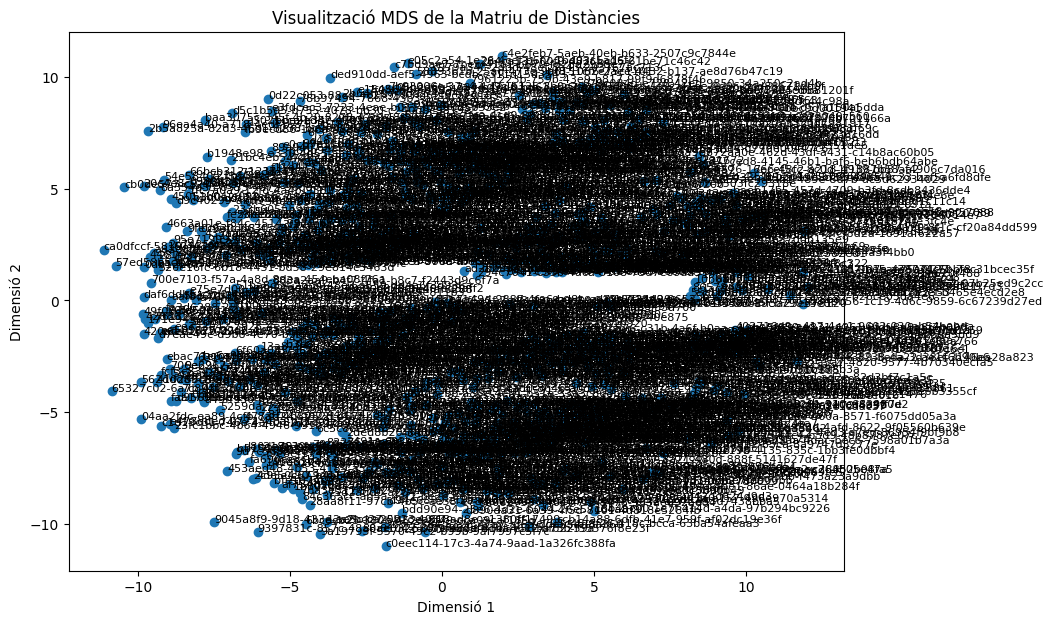

In [ ]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)

# Aplicar MDS per obtenir les coordenades en 2D
coordenades_2d = mds.fit_transform(matrix)

# Convertir les coordenades a un DataFrame per a una visualització més fàcil  
df_coordenades = pd.DataFrame(coordenades_2d, columns=['Dim1', 'Dim2'], index=ids)

# Visualització del resultat
plt.figure(figsize=(10, 7))
plt.scatter(df_coordenades['Dim1'], df_coordenades['Dim2'])

# Afegir etiquetes per a cada punt
for id_participant, (x, y) in df_coordenades.iterrows():
    plt.text(x, y, id_participant, fontsize=8)

plt.title('Visualització MDS de la Matriu de Distàncies')
plt.xlabel('Dimensió 1')
plt.ylabel('Dimensió 2')
plt.show()

In [ ]:
for id_participant, (x, y) in df_coordenades.iterrows():
    if np.random.rand() > 0.75:  
        plt.text(x, y, id_participant, fontsize=7)

plt.title('Visualització MDS de la Matriu de Distàncies (924x924)')
plt.xlabel('Dimensió 1')
plt.ylabel('Dimensió 2')
plt.show()

In [ ]:
df = pd.read_csv('distance_matrix.csv', index_col=0)  # First column as index
matrix = df.to_numpy()  # Get just the numeric data as matrix
row_labels = df.index.tolist() # Get the string indices


array([[ 0.        , 11.07060631,  9.45992238, ...,  9.78549991,
         9.26856583,  9.07304518],
       [11.07060631,  0.        ,  9.59428303, ..., 12.17325877,
        12.41347532, 12.81251797],
       [ 9.45992238,  9.59428303,  0.        , ..., 10.12082192,
        11.17231537, 11.52022356],
       ...,
       [ 9.78549991, 12.17325877, 10.12082192, ...,  0.        ,
        14.09533141, 11.68040654],
       [ 9.26856583, 12.41347532, 11.17231537, ..., 14.09533141,
         0.        ,  7.78427402],
       [ 9.07304518, 12.81251797, 11.52022356, ..., 11.68040654,
         7.78427402,  0.        ]])

In [ ]:
import random
import math
from itertools import combinations
# Exemple de funció de distància (energía)
def distancia(grup):
    # Implementar la teva funció de distància aquí
    # Exemples d'atributs que podries considerar:
    return sum([combined_distance(participants_dict[x], participants_dict[y], weights, max_values, min_values) for x,y in combinations(grup,2)])



# Funció de simulació annealing
def simulated_annealing(participants, temperatura_inicial=1000, refredament=0.995, max_iteracions=10000):
    # Inicialització
    millor_solucio = generar_grups_aleatoris(participants)
    print(millor_solucio)
    millor_energia = calcular_energia(millor_solucio)
    temperatura = temperatura_inicial
    
    for iteracio in range(max_iteracions):
        # Crear una nova solució candidata
        nova_solucio = millor_solucio[:]
        muta_grups_aleatoriament(nova_solucio)
        
        # Calcular l'energia de la nova solució
        nova_energia = calcular_energia(nova_solucio)
        
        # Determinar si acceptar la nova solució
        if nova_energia < millor_energia:
            millor_solucio = nova_solucio
            millor_energia = nova_energia
            print(millor_energia)
        else:
            probabilitat_acceptacio = math.exp((millor_energia - nova_energia) / temperatura)
            if random.random() < probabilitat_acceptacio:
                millor_solucio = nova_solucio
                millor_energia = nova_energia
        
        # Refredament
        temperatura *= refredament
    
    return millor_solucio, millor_energia

# Funcions auxiliars
def generar_grups_aleatoris(participants):
    random.shuffle(participants)
    return [participants[i:i + 4] for i in range(0, len(participants), 4)]

def calcular_energia(grups):
    return sum(distancia(grup) for grup in grups)

def muta_grups_aleatoriament(grups):
    # Exemples de mútacions:
    grup1, grup2 = random.sample(grups, 2)
    p1 = random.choice(grup1)
    p2 = random.choice(grup2)
    grup1.remove(p1)
    grup2.remove(p2)
    grup1.append(p2)
    grup2.append(p1)

participants = list(participants_dict.keys())  
millor_grup, millor_energia = simulated_annealing(participants)


0.0

KeyboardInterrupt: 

In [132]:
print(millor_energia)

0.0

In [125]:
print(combined_distance(participants_dict['06fdb5ce-f35d-4afd-8622-9f05560b639e'],participants_dict['c8375f0e-fecd-4c63-931b-c1e8e29ab4e5'],weights, min_values, max_values))

13.872422158891066